In [4]:
import specdist as pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import LineCollection
from matplotlib.ticker import LogLocator
import re
scientific_notation = pi.scientific_notation
from scipy.linalg import cholesky, LinAlgError
from scipy.linalg import block_diag
from numpy import linalg as LA


from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import warnings; warnings.simplefilter('ignore')

path_to_figures = "/Users/boris/Work/SPECTRAL-DISTORTIONS/figures/"

xinj_to_mass = 4.698e-4 #m in ev = 4.698e-4 xinj
xinj_to_Einj = 4.698e-4/2. #Einj = 4.698e-4/2 xinj
mass_to_Einj = 1./2.
#1./4.698e-4*2. = 4257.130693912303

# sd_lib_bare = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('bare',sd_lib_bare)


# sd_lib_lyc = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)


from matplotlib.patches import Patch
from matplotlib.lines import Line2D

label_y_firas = r'$y_\mathrm{COBE}=1.5\times 10^{-5}$'
label_mu_firas = r'$\mu_\mathrm{COBE}=9\times 10^{-5}$'
label_fdm = 'Effective Dark Matter Fraction, '+r'$\epsilon f_\mathrm{dm}$'
label_mdm = 'Particle Mass,  ' +r'$m_\mathrm{X}\quad[\mathrm{eV}]$'
label_xe = 'Free Electron Fraction, '+r'$X_\mathrm{e}$'
label_Zeta_e = 'Ionization History, '+r'$\zeta(z) = \Delta X_\mathrm{e}/X_\mathrm{e}$'
label_redshift = 'Redshift, '+r'$z$'
label_mu_dist =  'Chemical Potential, '+r'$\mu$'
label_injection_frequency = "Scaled Injection Frequency, "+ r'$x_{\mathrm{inj,0}}$'
label_scaled_frequency = "Scaled Frequency, "+ r'$x=h\nu/k_{_\mathrm{B}}T_{_\mathrm{CMB}}$'
label_frequency_in_GHz = "Frequency,  "+ r'$\nu \quad [\mathrm{GHz}]$'
label_intensity = "Intensity, "+r'$\Delta I_x \quad [\mathrm{Jy/sr}]$'
label_intensity_kJy = "Intensity, "+r'$\Delta I_x \quad [\mathrm{kJy/sr}]$'
label_injection_energy = "Injection Energy, "+ r'$E_{\mathrm{inj,0}}$' + " [eV]"

label_Gamma = "Decay Rate, "+r"$\Gamma_X\quad[\mathrm{s^{-1}}]$"

label_Gamma_stim = r"$\Gamma_X^\mathrm{stim}/\Gamma_X=[1+2n_\mathrm{Pl}(x_\mathrm{inj})]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'

label_log10Tau_x = "Lifetime,  "+r'$\mathrm{log}_{10}(\tau_X/\,1\mathrm{s})$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'
label_log10injection_energy = "Injection Energy, "+ r'$\mathrm{log}_{10}(E_{\mathrm{inj,0}}/\,1\mathrm{eV})$'
label_log10mdm = 'Particle Mass, ' +r'$\mathrm{log}_{10}(m_\mathrm{X}/\,1\mathrm{eV})$'
sd = pi


find_nearests = sd.find_nearests
#from scipy.interpolate import interp1d

def get_fdm_constraints_at_Gamma_and_xinj(gamma_p,xinj_p,*args,**kwargs):
    a_lib = kwargs['sd_lib']
    f_dm_fisher = sd.pi_run_fisher_constraints([gamma_p],[xinj_p],**kwargs)
    fdm_value = f_dm_fisher['curves'][0]['fdm'][0]
    #x_asked = np.logspace(np.log10(1e-8),np.log10(1e8),3000)
    #fdm_value = GetSpectra(gamma_p,xinj_p,x_asked,a_lib,get_fisher_fdm='yes',use_edges='yes')["fisher_fdm"]
    fdm_pca_value_ct = np.nan
    fdm_pca_value_rf = np.nan
    if gamma_p < 1e-12:
        # using recfast:
        #f_dm_pca = pi_run_pca_constraints_with_recfast([xinj_p],[gamma_p],fdm_value,**kwargs)
        #fdm_pca_value_rf = f_dm_pca['curves'][0]['fdm'][0]
        
        # using CT:
        z_asked = np.logspace(np.log10(1e-2),np.log10(4000),5000)
        S_xe_history = sd.GetXeHistory(gamma_p,xinj_p,z_asked,a_lib)
        fdm_pca_value_ct = S_xe_history['fdm_pca_lim']
    r_dict = {}
    r_dict['fdm_fisher'] = fdm_value
    r_dict['fdm_Xe_pca_rf'] = fdm_pca_value_rf
    r_dict['fdm_Xe_pca_ct'] = fdm_pca_value_ct
    return r_dict

def pi_run_pca_constraints_with_recfast(xinj_values,gammai_array,fdm,*args,**kwargs):
    PCA_eigen_modes = kwargs['PCA_modes']
    recfast = kwargs['recfast']
    f_dm_pca = {}
    f_dm_pca['curves'] = []
    f_dm_pca['xinj'] = []
    
    store_DXe_Xe = kwargs.get('store_DXe_Xe', 'no')
    
    
    z1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['z']
    E1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['values']
    z2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['z']
    E2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['values']
    z3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['z']
    E3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['values']
    
    f_E1 = interp1d(z1, E1)
    f_E2 = interp1d(z2, E2)
    f_E3 = interp1d(z3, E3)

    
    for xinj_asked in xinj_values:
        xdec = xinj_asked
        curves = {}
        curves['Gamma_inj'] = gammai_array
        if store_DXe_Xe == 'yes':
            curves['DXe_Xe'] = []

        #str_dir = str("%.3e"%xdec)

        recfast.rf_xinj0 = xdec
        recfast.rf_f_dec = fdm

        args = {}

        p_name = 'Gamma_dec'
        p_array = gammai_array

        args['param_values_array'] = p_array
        args['param_name'] = p_name
        args['save_recfast_results'] = 'no'
        #rf.save_dir_name = 'case_' + '_xdec_' + str_dir
        R = recfast.run_recfast_parallel(**args)


        recfast.rf_f_dec = 1.e-300
        #recfast.save_dir_name = 'case_no_inj' + '_xdec_' + str_dir
        R_no_inj = recfast.run_recfast_parallel(**args) 
        
        
        
        fdm_pca_array = []
        for k in range(len(R)):
            DXe_Xe = (R[k]['Xe']-R_no_inj[k]['Xe'])/R_no_inj[k]['Xe']
            z_Xe = R[k]['z']
            f_DXe_Xe = interp1d(z_Xe,DXe_Xe)
            
            min_z1 = max(np.min(z1),np.min(z_Xe))
            max_z1 = min(np.max(z1),np.max(z_Xe))

            min_z2 = max(np.min(z2),np.min(z_Xe))
            max_z2 = min(np.max(z2),np.max(z_Xe))

            min_z3 = max(np.min(z3),np.min(z_Xe))
            max_z3 = min(np.max(z3),np.max(z_Xe))
            
            new_z_min = max(min_z1,min_z2,min_z3)
            new_z_max = min(max_z1,max_z2,max_z3)
            
            new_z_min = 1e-5
            new_z_max = 4e3
            new_z = np.linspace(new_z_min,new_z_max,500)

            
            new_z1 = new_z#np.linspace(min_z1,max_z1,5000)
            new_z2 = new_z#np.linspace(min_z2,max_z2,5000)
            new_z3 = new_z#np.linspace(min_z3,max_z3,5000)
            
            zeta1 = f_DXe_Xe(new_z1)
            zeta2 = f_DXe_Xe(new_z2)
            zeta3 = f_DXe_Xe(new_z3)

            integrand_rho1 = zeta1*f_E1(new_z1)
            integrand_rho2 = zeta2*f_E2(new_z2)
            integrand_rho3 = zeta3*f_E3(new_z3)
            
            

            rho1 = np.trapz(integrand_rho1, x=new_z1)/fdm
            rho2 = np.trapz(integrand_rho2, x=new_z2)/fdm
            rho3 = np.trapz(integrand_rho3, x=new_z3)/fdm
            #print(rho1,rho2,rho3)

            sigma1 = 0.12
            sigma2 = 0.19
            sigma3 = 0.35

            fdm_pca_lim = 2.*1./np.sqrt(rho1**2/sigma1**2+rho2**2/sigma2**2+rho3**2/sigma3**2)
            fdm_pca_array.append(fdm_pca_lim)
            if store_DXe_Xe == 'yes':
                curves['DXe_Xe'].append([new_z,f_DXe_Xe(new_z)])
                
            
        fdm_pca_array = np.asarray(fdm_pca_array)
        curves['fdm'] = fdm_pca_array
        
        
        
        
        
        f_dm_pca['xinj'].append(xdec)
        f_dm_pca['curves'].append(curves)
    return f_dm_pca


import matplotlib.animation as animation

In [2]:
sd.path_to_cosmotherm

'/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr'

In [3]:
t_stim = np.loadtxt(sd.path_to_cosmotherm+'/t_stim.dat')

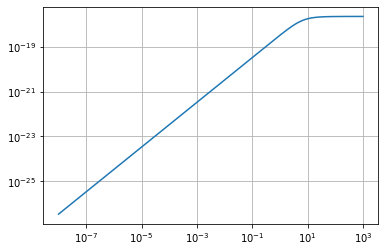

In [10]:
plt.plot(t_stim[:,0],t_stim[:,2])
plt.loglog()
plt.grid(which='both')

In [ ]:
        ofile << x << " " << 1.0/cosm.t(0.0) << " " << 1.0/t_dec_stim(0.0, x, cosm)
                   << " " << cosm.H(0)*x/7.0 << endl;

In [73]:
drho_stim = np.loadtxt(sd.path_to_cosmotherm+'/outputs/energetics.cooling.photon_inj.PDE_ODE.pistim.dat')

(0.01, 10000000.0)

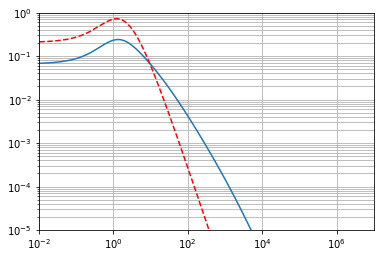

In [74]:
plt.plot(drho_stim[:,0],drho_stim[:,17]/drho_stim[:,18][-1])
plt.plot(drho_stim[:,0],drho_stim[:,16]/drho_stim[:,19][-1],c='r',ls='--')
#plt.plot(drho_stim[:,0],-drho_stim[:,18], ls='--')
plt.loglog()
plt.grid(which='both')
plt.ylim(1e-5,1e0)
plt.xlim(1e-2,1e7)

(0.01, 10000000.0)

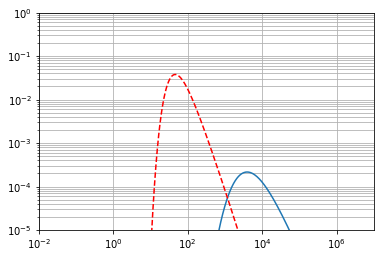

In [72]:
plt.plot(drho_stim[:,0],drho_stim[:,17])
plt.plot(drho_stim[:,0],drho_stim[:,16],c='r',ls='--')
#plt.plot(drho_stim[:,0],-drho_stim[:,18], ls='--')
plt.loglog()
plt.grid(which='both')
plt.ylim(1e-5,1e0)
plt.xlim(1e-2,1e7)

In [2]:
def xinj_at_z(x0,z):
    return x0/(1.+z)

def n_bb(x):
    return (np.exp(x)-1.)**-1.




def Gamma_stim_over_Gamma_X(xinj0,zp):
    xinj = xinj_at_z(xinj0,zp)
    return (1.+2*n_bb(xinj))



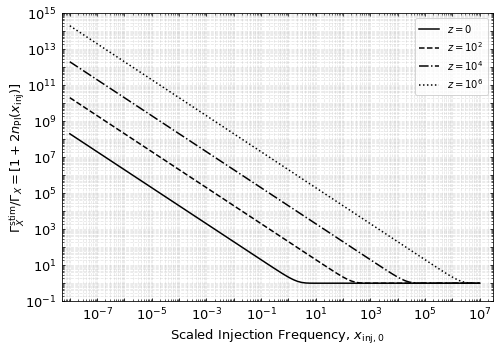

In [3]:

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 13
title_size = 13
legend_size = 25
handle_length = 1.5


ax.set_xscale('log')
ax.set_yscale('log')

# ymin=1e-6
# ymax = 2e-2
# x_min = 1e1
# x_max = 1e8
# ax.set_xlim(x_min,x_max)
# ax.set_ylim(ymin,ymax)


ax.set_ylabel(label_Gamma_stim,size=title_size)
ax.set_xlabel(label_injection_frequency,size=title_size)
ax.yaxis.set_label_coords(-.08,0.5)

#for label in ax.yaxis.get_ticklabels()[::2]:
#    label.set_visible(True) #(3)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)





ax.grid( b=True, which="both", alpha=0.3, linestyle='--')




array_x0 = np.logspace(-8,7,100)

z = 0.
ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=0$',ls='-',c='k')
z = 1e2
ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{2}$',ls='--',c='k')
z = 1e4
ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{4}$',ls='-.',c='k')
z = 1e6
ax.plot(array_x0, Gamma_stim_over_Gamma_X(array_x0,z),label=r'$z=10^{6}$',ls=':',c='k')





ax.legend()

ax.set_ylim(1.e-1,1e15)
ax.set_xlim(5.e-9,3e7)

fig.tight_layout()
#plt.savefig(path_to_figures + '/figures_for_paper_Gamma_stim.pdf')
plt.show()
plt.close(fig)

In [5]:
Gamma_inj_min = 1e-18
Gamma_inj_max = 1e-8
N_Gamma_inj = 11
Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
N_Gamma_inj = len(Gamma_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

ngamma = N_Gamma_inj 


args = {}
args['param_values_array'] = Gamma_values
args['param_name'] = 'photon injection Gamma_dec'

ct = pi.cosmotherm()
ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)

In [8]:
z_array = []
Drho_array = []
i=0
for r,Gamma_asked in zip(R,Gamma_values):
    #print(Gamma_asked)

    #col = next(color)
    #slabel = r"$\Gamma_\mathrm{inj} = $"+scientific_notation(Gamma_asked)
    #ax.plot(r["z"],r["dDrho_rhodt_rel"],c=col,label=slabel)
    
    ct.ct_Gamma_dec = Gamma_asked
    cosmo = pi.cosmo()
    pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
    #print(ct.ct_Gamma_dec)
    
    
    z_array.append(np.logspace(np.log10(cosmo.z_start),np.log10(cosmo.z_end),200))
    #Drho_array.append(pi.Drho_rho_inj_at_z_normalized(z_array[i],cosmo,ct))
    i+=1

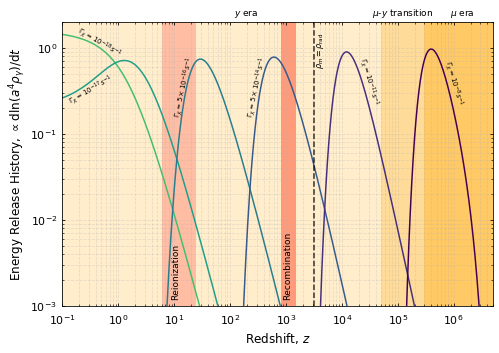

In [12]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 11
title_size = 12
legend_size = 25
handle_length = 1.5




ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(r"Energy Release History, $\propto \mathrm{d}\ln (a^4 \rho_\gamma)/\mathrm{d}t$",size=title_size)
ax.yaxis.set_label_coords(-.08,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.514, 0.03, 'Recombination', transform=ax.transAxes,color='k',rotation=90,fontsize=9)

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
        rotation=0)

ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(6., 25, facecolor='red', alpha=0.2)
ax.text(0.253, 0.03, 'Reionization', transform=ax.transAxes,color='k',rotation=90,fontsize=9)



color=iter(cm.viridis(np.linspace(0.7,0.,ngamma)))

i = 0
for r,Gamma_asked in zip(R,Gamma_values):
    #print(Gamma_asked)

    col = next(color)
    slabel = r"$\Gamma_\mathrm{inj} = $"+scientific_notation(Gamma_asked)
    ax.plot(r["z"],r["dDrho_rhodt_rel"],c=col,ls='-',alpha=1.,label=slabel)
    
    ct.ct_Gamma_dec = Gamma_asked
    cosmo = pi.cosmo()
    pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)
    #print(ct.ct_Gamma_dec)
    
    
#     z_array = np.logspace(np.log10(cosmo.z_start),np.log10(cosmo.z_end),200)
#     Drho_array=pi.Drho_rho_inj_at_z_normalized(z_array,cosmo,ct)

    #ax.plot(z_array[i],np.abs(Drho_array[i]),c=col,ls='-',alpha=1.)      
    try:
        zX = pi.injection_redshift_zX(Gamma_asked,cosmo,ct)
        #ax.axvline(zX)
        #print(zX)
    except:
        zX = 0.
    i+=1

ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.8)
ax.text(0.588, 0.85, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', fontsize=8,transform=ax.transAxes,color='k',rotation=90)

#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
ax.text(0.03, 0.875, r'$\Gamma_X = 10^{-18}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=-30)


ax.text(0.01, 0.71, r'$\Gamma_X = 10^{-17}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=30)

ax.text(0.255, 0.671, r'$\Gamma_X = 5\times 10^{-16}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=78)

ax.text(0.425, 0.671, r'$\Gamma_X = 5\times 10^{-14}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=78)

ax.text(0.6825, 0.71, r'$\Gamma_X = 10^{-11}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=-74)

ax.text(0.88, 0.71, r'$\Gamma_X = 10^{-8}\,s^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
        rotation=-74)




ax.loglog()
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
# cbar = plt.colorbar(sm)
# cbar.set_ticks([0.,0.2,0.4,0.6,0.8,1.])
# cbar.ax.set_yticklabels([r'$10^{-8}$',r'$10^{-10}$',r'$10^{-12}$',r'$10^{-14}$',r'$10^{-16}$',r'$10^{-18}$'])
# cbar.ax.set_title(r'$\Gamma_\mathrm{inj}\,[\mathrm{s}^{-1}]$')

fig.tight_layout()
#plt.savefig(path_to_figures + '/figures_for_paper_drho_rho.pdf')
plt.show()
plt.close(fig)